In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import calmap
import datetime
import tensorflow as tf
import os
import random
import re
import plotly.offline as pyoff
import plotly.graph_objs as go

from datetime import date
from plotly.subplots import make_subplots
from itertools import cycle, product
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from pmdarima.arima import ADFTest, KPSSTest, auto_arima
from pmdarima.utils import diff_inv
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p, inv_boxcox1p
import matplotlib.patches as mpatches
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from IPython.core.display import HTML, display

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher" --iversions

Author: Herikc Brecher

datetime    : 4.3
numpy       : 1.19.5
calmap      : 0.0.9
matplotlib  : 3.4.2
seaborn     : 0.11.1
tensorflow  : 2.5.0
re          : 2.2.1
plotly      : 4.14.3
pandas      : 1.2.2
chart_studio: 1.1.0



In [3]:
# Variaveis globais
SEED = 84796315
FEATURES = 5
EPOCHS = 30
BATCH_SIZE = 1000
EXECUTE_GRID_SEARCH = True

In [4]:
# Configurando seeds
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# Exibindo toda tela
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. Preparando Conjunto de Pedidos

In [6]:
# Import dataset
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')

In [7]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAdjusted = dtOrders.copy()

In [8]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAdjusted[col] = pd.to_datetime(dtOrdersAdjusted[col], format = '%Y-%m-%d %H:%M:%S')

In [9]:
# Dropando valores NA
dtOrdersAdjusted = dtOrdersAdjusted.dropna()

In [10]:
dtOrdersAdjusted.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

# 2. Iniciando Analise Seasonal

In [11]:
dtHistory = pd.to_datetime(dtOrdersAdjusted['order_purchase_timestamp']).dt.date

start = dtHistory.min()
end = dtHistory.max()

idx = pd.date_range(start, end, normalize=True)

seriesHistory = dtHistory.value_counts(sort=False).sort_index().reindex(idx, fill_value=0)

dtHistory = pd.DataFrame(seriesHistory).reset_index()

Principais outliers identificados:

- 1 de setembro de 2016 a 31 de dezembro de 2016: Dados quase inexistentes
- 24 de novembro de 2017: Pico de venda devido ao evento da blackfriday
- 17 de agosto de 2017 a 17 de outubro de 2017: Queda repentina nos dados

In [12]:
dtHistory

index  order_purchase_timestamp
0   2016-09-15                         1
1   2016-09-16                         0
2   2016-09-17                         0
3   2016-09-18                         0
4   2016-09-19                         0
..         ...                       ...
709 2018-08-25                        69
710 2018-08-26                        73
711 2018-08-27                        66
712 2018-08-28                        39
713 2018-08-29                        11

[714 rows x 2 columns]

In [13]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {"title": 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

In [14]:
# Remove outliers
seriesHistory = seriesHistory[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_range = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))
dtHistory = pd.DataFrame(seriesHistory).reset_index()

In [15]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {"title": 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

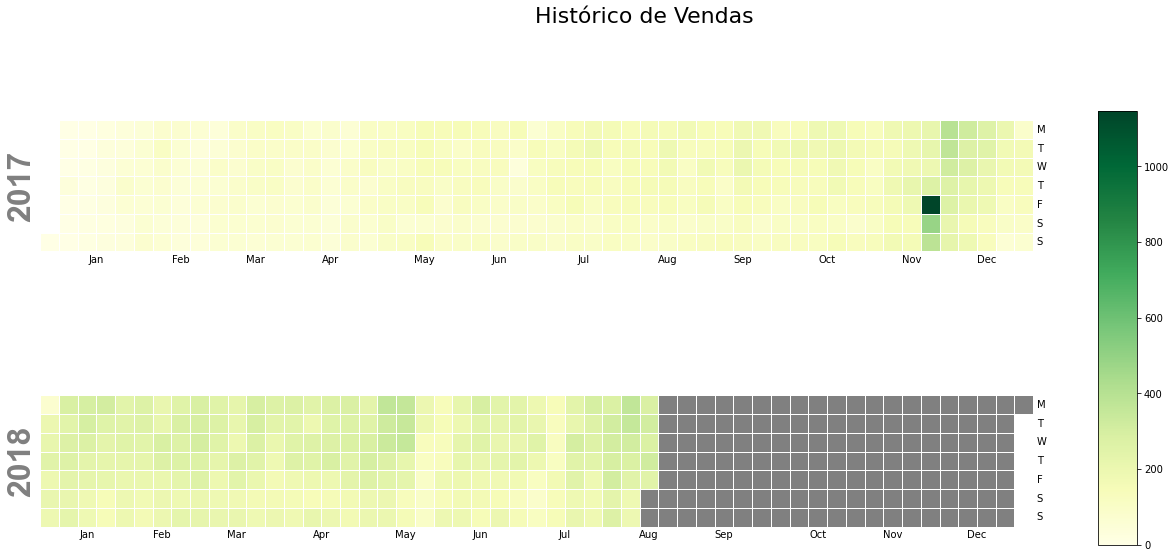

In [16]:
#Plot histórico de vendas por dia, mês e ano
fig, caxs = calmap.calendarplot(seriesHistory, daylabels='MTWTFSS', fillcolor='grey',cmap='YlGn', fig_kws=dict(figsize=(18, 9)))
fig.suptitle('Histórico de Vendas', fontsize=22)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.67])
fig.colorbar(caxs[0].get_children()[1], cax=cbar_ax)

plt.show()

In [17]:
# Criar grafico na estrutura STL 4 layers
def add_stl_plot(fig, res, legend):
    axs = fig.get_axes()
    
    # Nome de cada um dos subplots
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            ax.legend(legend, frameon=False)

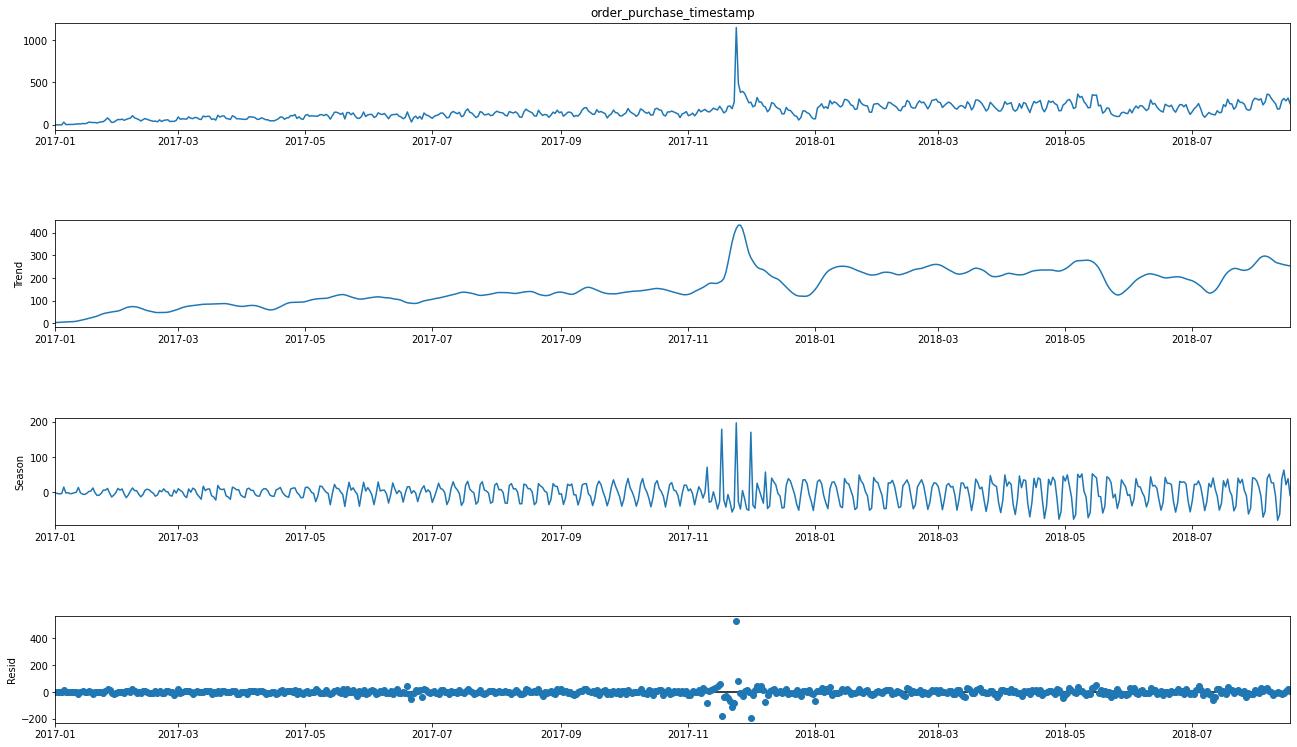

In [18]:
# Gerar STL
stl = STL(seriesHistory)
stl_res = stl.fit()
fig = stl_res.plot()
fig.set_size_inches((20, 12))
plt.show()

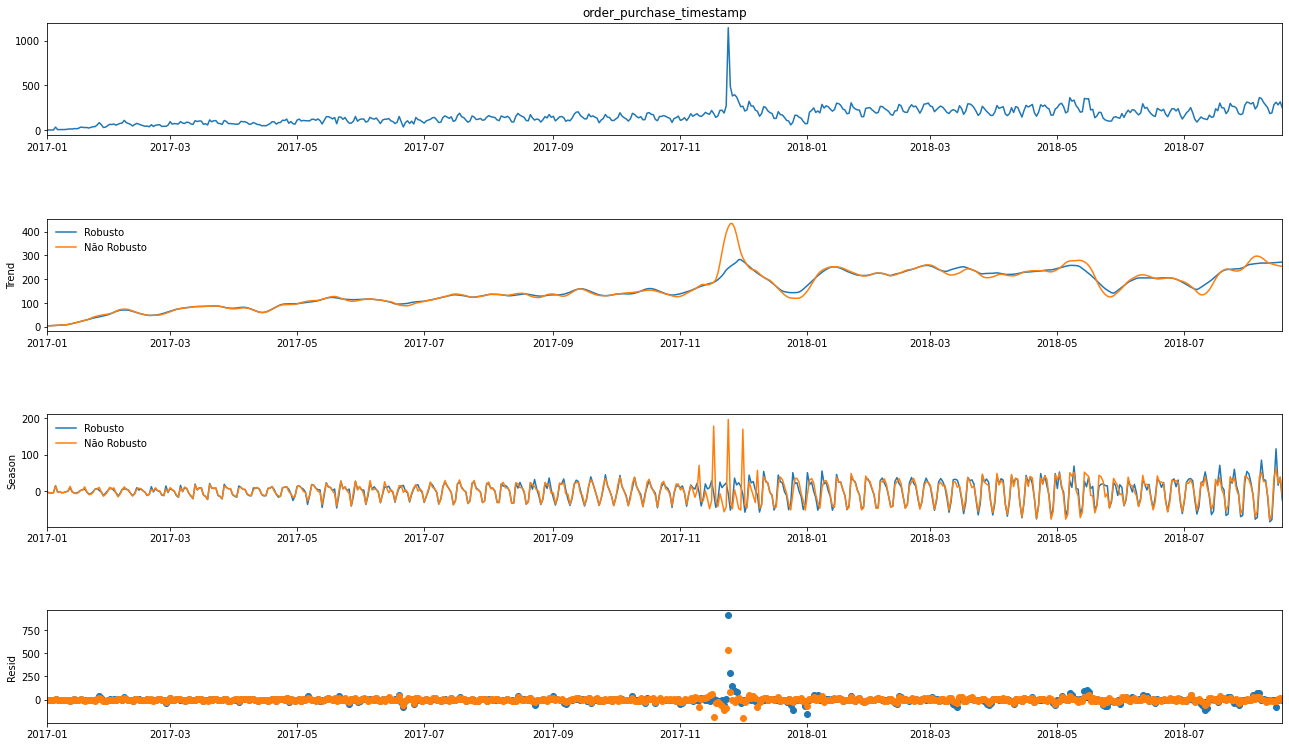

In [19]:
# Gerar STL não robusto e concatenar ao robusto
stl = STL(seriesHistory, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
fig.set_size_inches((20, 12))
res_non_robust = STL(seriesHistory, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robusto", "Não Robusto"])

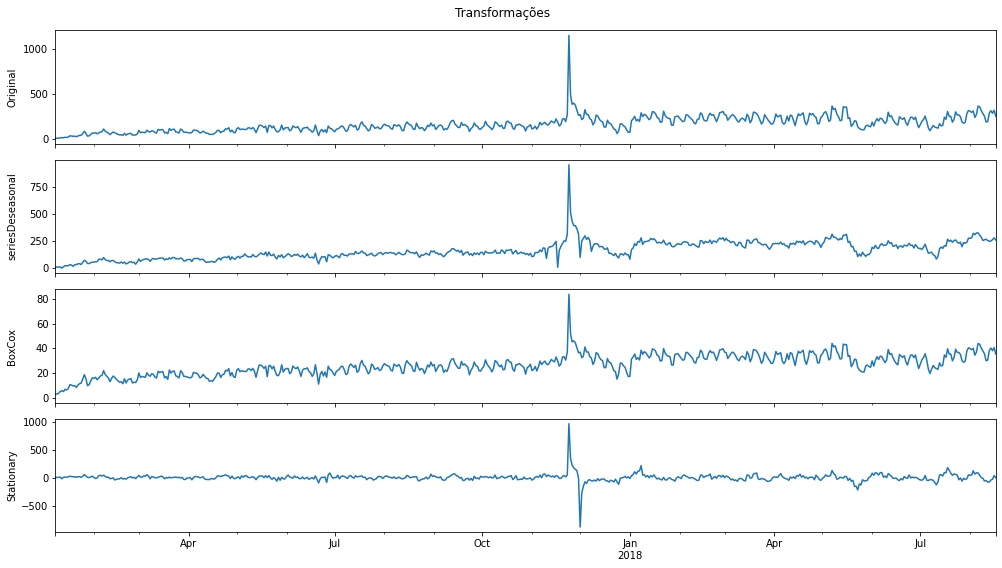

In [20]:
# Gerando STL para separar cada um dos componentes
stl = STL(seriesHistory)
res = stl.fit()

# Separando seriesDeseasonal
seriesDeseasonal = res.observed - res.seasonal

# Separando boxcox
seriesBoxCox, lmbda = boxcox(seriesHistory+1)
seriesBoxCox = pd.Series(seriesBoxCox, index=seriesHistory.index)

# Separando stationary
seriesDiffHistory = seriesHistory.diff(7).dropna()
xi = seriesHistory.iloc[:7]

# Plotando todos elementos de forma separada
fig, axs = plt.subplots(nrows=4, sharex=True, figsize=(14, 8))
seriesHistory.plot(ax=axs[0])
axs[0].set_ylabel('Original')
seriesDeseasonal.plot(ax=axs[1])
axs[1].set_ylabel('Deseasonal')
seriesBoxCox.plot(ax=axs[2])
axs[2].set_ylabel('BoxCox')
seriesDiffHistory.plot(ax=axs[3])
axs[3].set_ylabel('Stationary')
fig.align_ylabels()
fig.suptitle('Transformações')
plt.tight_layout()
plt.show()

## 2.1 Testes

Os testes abaixo concluiram:

- ADF: O teste aceita a hipótese alternativa em que a série é estácionária.

- KPSS: O teste aceita a hipótese alternativa em que a série não é estácionária.

### 2.1.1 ADF:

ADF teste:

- Hipótese Nula(HO): A série possui unit root ou não é estacionária.
- Hipótese Alternativa(HA):  A série não possui unit root ou é estacionária.

In [21]:
# Teste ADF automatizado
def adf_test(series):
    result = adfuller(series, autolag='AIC')

    print(f'ADF: {result[0]}')
    print(f'steps: {result[1]}')
    print(f'p-value: {result[1]}')

    for key, value in result[4].items():
        print('\nValor Critico:')
        print(f'   {key}: {value}')    

In [22]:
adf = ADFTest(alpha = 0.05)
adf.should_diff(seriesHistory)

(0.01, False)

In [23]:
# Testando estacionaridade na série original
adf_test(seriesHistory)

ADF: -2.6163082378564684
steps: 0.08967331201291256
p-value: 0.08967331201291256

Valor Critico:
   1%: -3.441694608475642

Valor Critico:
   5%: -2.866544718556839

Valor Critico:
   10%: -2.5694353738653684


In [24]:
adf.should_diff(seriesDiffHistory)

(0.01, False)

In [25]:
adf_test(seriesDiffHistory)

ADF: -6.801606152090551
steps: 2.229745766641977e-09
p-value: 2.229745766641977e-09

Valor Critico:
   1%: -3.441834071558759

Valor Critico:
   5%: -2.8666061267054626

Valor Critico:
   10%: -2.569468095872659


### 2.1.2 KPSS:

KPSS teste:

- Hipótese Nula (HO): A série não possui unit root ou é estacionária.
- Hipótese Alternativa(HA): A série possui unit root ou não é estacionária.

In [26]:
kpss = KPSSTest(alpha = 0.05)

# Testando estacionaridade na série original com KPSS
kpss.should_diff(seriesHistory)

(0.01, True)

In [27]:
kpss.should_diff(seriesDiffHistory)

(0.1, False)

# 3. Modelagem

Toda a etapa de modelagem será considerada com 5 passos a frente de previsão.

In [28]:
# Controle de resultados de toda fase de modelagem
result = pd.DataFrame(columns=['Algorithm', 'MSE', 'RMSE', 'MAE', 'Mean_Real_Value', 'Mean_Predict_Value'])

In [29]:
split_range = TimeSeriesSplit(n_splits = 8, max_train_size = pred_range.shape[0], test_size = pred_range.shape[0])

In [30]:
# Adiciona o registro ao dataset
def record(result, algorithm, mse = -1, rmse = -1, mae = -1, mrv = -1, mpv = -1, show = True):
    new = pd.DataFrame(dict(Algorithm = algorithm, MSE = mse, RMSE = rmse, MAE = mae, Mean_Real_Value = mrv,\
                            Mean_Predict_Value = mpv), index=[0])
    result = pd.concat([result, new], ignore_index=True)
    
    if show:
        display(result)
    
    return result

In [31]:
# Plot no formato de 4 layers, seguindo o STL para cada um dos modelos
def plot(index, pred, mse, title, fig = None, ax = None, ylabel = ''):
    global seriesHistory
    
    empty_fig = fig is None
    
    if empty_fig:
        fig, ax = plt.subplots(figsize=(13, 6))
    else: 
        ax.set_ylabel(ylabel)
                
    ax.set_title(title)    
    patch_ = mpatches.Patch(color = 'white', label = f'MSE: {np.mean(mse):.1e}')
    L1 = ax.legend(handles = [patch_], loc = 'upper left', fancybox = True, framealpha = 0.7,  handlelength = 0)
    ax.add_artist(L1)
    
    sns.lineplot(x = seriesHistory.index, y = seriesHistory, label = 'Real', ax = ax)
    sns.lineplot(x = index, y = pred, label = 'Previsto', ax = ax)
    ax.axvline(x = index[0], color = 'red')
    ax.legend(loc = 'upper right')
    
    if empty_fig:
        plt.show()
    else:
        return fig

In [32]:
'''
Correção da função diff_inv original que apresenta problemas ainda não corrigidos:
https://github.com/alkaline-ml/pmdarima/issues/410
'''

def diff_inv_fix(x_diff, xi, column, steps = 1):
    total_len = len(x_diff) + len(xi)
    
    ix = pd.date_range(xi.index[0], periods = total_len)  
    inv = diff_inv(x_diff, steps, xi = xi) + np.fromiter(cycle(xi), count = total_len, dtype = float)  
    inv = pd.Series(inv, index = ix, name = column)
    
    return inv

In [33]:
# Calculo para previsão e teste quando utilizado a série Original
def calcPredTestOriginal(train, pred, test):
    return pred, test, 0

In [34]:
# Calculo para previsão e teste quando utilizado a série seriesDeseasonal
def calcPredTestseriesDeseasonal(train, pred, test):
    # Removendo a sazonalidade da série e convertendo para o shape correto
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    pred = pred + np.fromiter(cycle(last_seasonal), count = pred.shape[0], dtype = float)
    test = test + res.seasonal.reindex_like(test)
    
    return pred, test, 1

In [35]:
# Calculo para previsão e teste quando utilizado a série BoxCox
def calcPredTestBoxCox(train, pred, test):
    # Reverdendo a normalização do boxcox
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    
    return pred, test, 2

In [36]:
# Calculo para previsão e teste quando utilizado a série Stationary
def calcPredTestStationary(train, pred, test):
    # Calculando a diferença da sazonalidade
    xi = seriesHistory.reindex_like(train).tail(FEATURES)
    pred = diff_inv_fix(pred, xi, 'order_purchase_timestamp', FEATURES).iloc[FEATURES:]
    test = diff_inv_fix(test, xi, 'order_purchase_timestamp', FEATURES).iloc[FEATURES:]
    
    return pred, test, 3

## 3.1 TSR (Time Series Regression)

In [37]:
# Report para Time Series Regressor, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportTSR(data, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Time Series Regression'
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        gen = TimeseriesGenerator(train, train, FEATURES, batch_size = BATCH_SIZE)

        X_train = gen[0][0]
        y_train = gen[0][1]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        X_pred = y_train[-FEATURES:].reshape(1,-1)
        pred = np.empty(test.shape[0])

        for i in range(len(pred)):
            forecast = lr.predict(X_pred)
            X_pred = np.delete(X_pred, 0, 1)
            X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
            pred[i] = forecast
        
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [38]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.tight_layout()
plt.close()

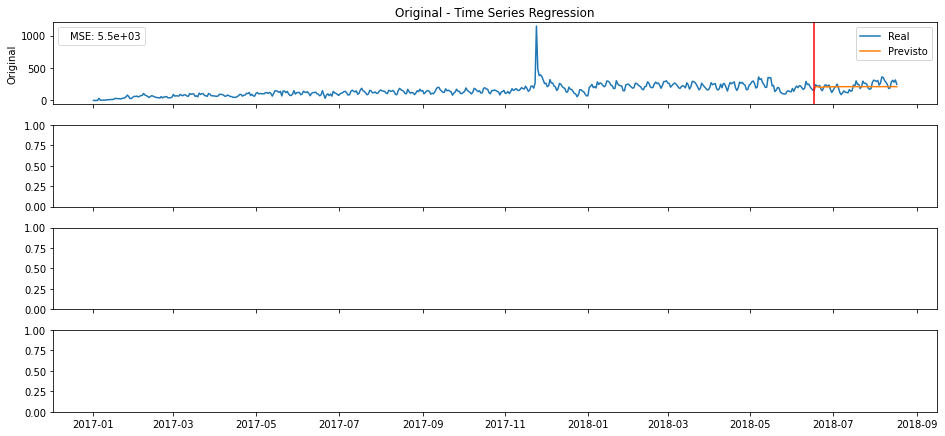

In [39]:
reportTSR(seriesHistory.copy(), 'Original', calcPredTestOriginal)

## 3.2 STL seriesDeseasonal - TSR (Time Series Regression)

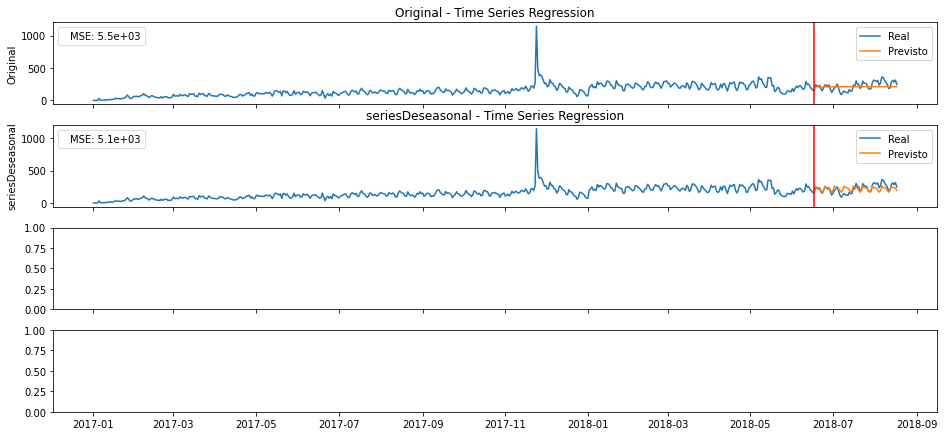

In [40]:
reportTSR(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.3 BoxCox - TSR (Time Series Regression)

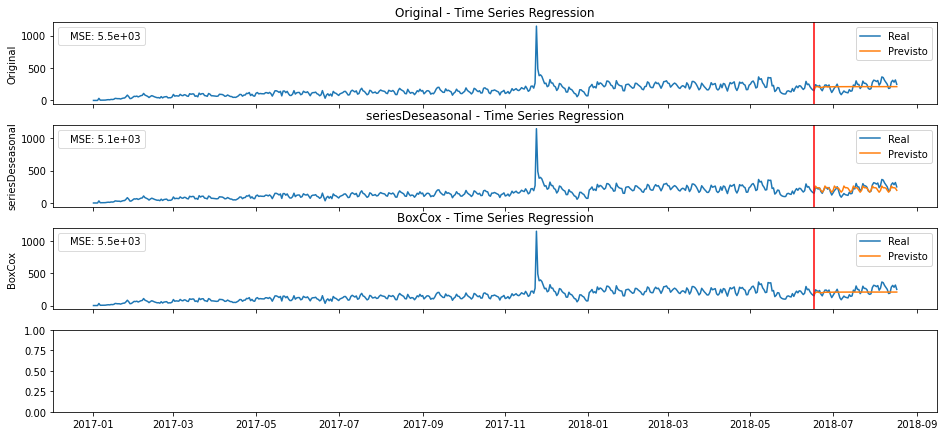

In [41]:
reportTSR(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox)

## 3.4 Stationary - TSR (Time Series Regression)

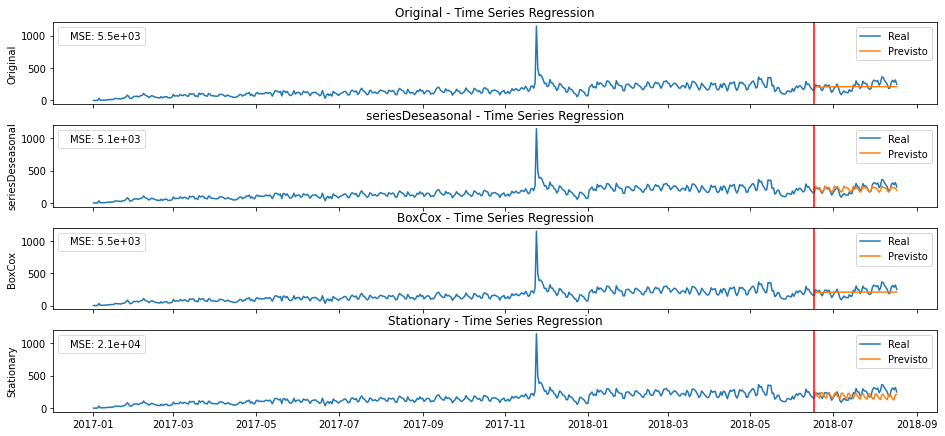

In [42]:
reportTSR(seriesDiffHistory.copy(), 'Stationary', calcPredTestStationary)

In [43]:
result

Algorithm           MSE        RMSE  \
0          Original - Time Series Regression   5485.688752   63.032946   
1  seriesDeseasonal - Time Series Regression   5070.936469   57.842363   
2            BoxCox - Time Series Regression   5531.781002   63.453289   
3        Stationary - Time Series Regression  20765.011179  123.412496   

         MAE  Mean_Real_Value  Mean_Predict_Value  
0  45.057261       179.560484          164.066513  
1  39.592783       179.560484          166.267257  
2  45.576572       179.560484          160.984010  
3  88.116806       181.296371          175.123977

## 3.5 Exponential Smoothing

In [44]:
# Função utilizada para o hypertuning de alpha, beta e gamma do Exponential Smoothing
def GSES(data, modelName, alpha, beta, gamma, calcFunction):    
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                ES = (
                    ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=FEATURES)
                    .fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal = gamma, method='ls')
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))
        
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [45]:
# Função utilizada para o hypertuning de demais parâmetros do Exponential Smoothing
def GSESOPT(data, modelName, trend, season, periods, bias, method, calcFunction):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings("ignore")
                ES = (
                    ExponentialSmoothing(train, trend = trend, seasonal = season, seasonal_periods = periods)
                    .fit(remove_bias = bias, method = method, optimized = True)
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))       
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [46]:
# Report para Exponential Smoothing, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportES(data, modelName, model_kwargs, fit_kwargs, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Exponential Smoothing'
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        ES = ExponentialSmoothing       
        stlf = STLForecast(train, ES, model_kwargs = model_kwargs).fit(fit_kwargs = fit_kwargs)
        pred = stlf.forecast(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [47]:
# Função para gerar tabela de hypertuning ampla
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # Lista de argumentos
    t_params = ['add', 'mul', None]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    r_params = [True, False]
    method_params = ['L-BFGS-B' , 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'bh', 'ls']
    
    # Gerando lista de argumentos
    for t in t_params:
        for s in s_params:
            for p in p_params:
                for r in r_params:
                    for m in method_params:
                        cfg = [t, s, p, r, m]
                        models.append(cfg)
    return models

In [48]:
# Gerando tabela de hypertunning
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [49]:
%%time

# Treinamento do modelo 
tuning['mse'] = tuning.apply(lambda x: GSES(seriesHistory.copy(), 'Original',\
                                            x.alpha, x.beta, x.gamma, calcPredTestOriginal), axis = 1)

Wall time: 58.7 s


In [50]:
# Verificando o menor mse
tuning.query('mse == mse.min() and mse != -1')

alpha  beta  gamma          mse
114    0.1   0.1    0.4  5786.805362

In [51]:
# Criando lista de argumentos ampla
params_ = exp_smoothing_configs([FEATURES])

In [52]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [53]:
len(tuning2)

126

In [54]:
tuning2.head()

trend season  periods  bias        method
0   add    add        5  True      L-BFGS-B
1   add    add        5  True           TNC
2   add    add        5  True         SLSQP
3   add    add        5  True        Powell
4   add    add        5  True  trust-constr

In [55]:
%%time

# Se True irá treinar com a nova lista mais ampla (pode demorar)
if EXECUTE_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSESOPT(seriesHistory.copy(), 'Original',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestOriginal),\
                                   axis = 1)

Wall time: 5min 8s


In [56]:
if EXECUTE_GRID_SEARCH:
    display(tuning2.query('mse == mse.min() and mse != -1'))

trend season  periods   bias  method          mse
122  None   None        5  False  Powell  5652.262932

In [57]:
# Reset da figura
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

In [58]:
# Dicionar de configurações de acordo com o hypertuning
model_kwargs = dict(trend = None, seasonal = None, seasonal_periods = FEATURES)
fit_kwargs = dict(remove_bias = False, smoothing_level = 0.1, smoothing_trend = 0.1, smoothing_seasonal = 0.3,\
                  method = 'Powell')

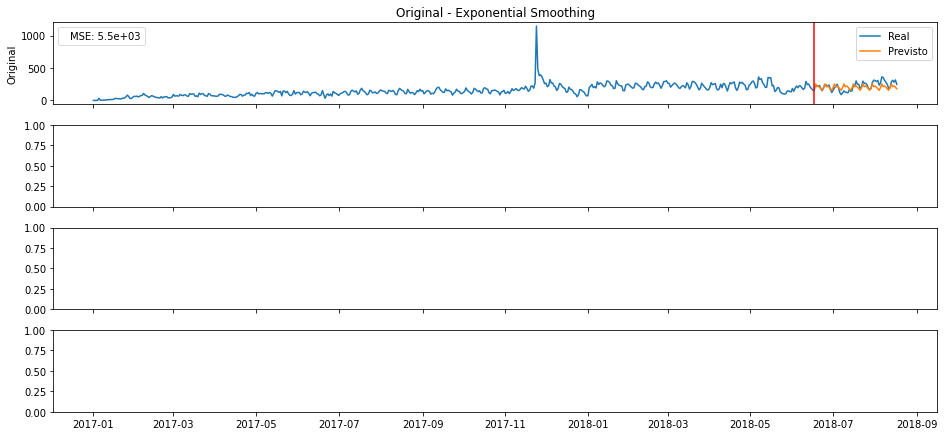

In [59]:
reportES(seriesHistory.copy(), 'Original', model_kwargs, fit_kwargs, calcPredTestOriginal)

## 3.6 seriesDeseasonal - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesHistory para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [60]:
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [61]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSES(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                            x.alpha, x.beta, x.gamma, calcPredTestseriesDeseasonal), axis=1)

Wall time: 1min 1s


In [62]:
tuning.query('mse == mse.min() and mse != -1')

alpha  beta  gamma          mse
109    0.1   0.0    0.9  5077.164246

In [63]:
params_ = exp_smoothing_configs([FEATURES])

In [64]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [65]:
%%time
if EXECUTE_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSESOPT(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestseriesDeseasonal),\
                                   axis = 1)

Wall time: 4min 53s


In [66]:
if EXECUTE_GRID_SEARCH:
    display(tuning2.query('mse == mse.min() and mse != -1'))

trend season  periods   bias  method          mse
122  None   None        5  False  Powell  5023.970922

In [67]:
model_kwargs = dict(trend = None, seasonal = 'add', seasonal_periods = FEATURES)
fit_kwargs = dict(remove_bias = True, smoothing_level = 0.1, smoothing_trend = 0.1, smoothing_seasonal = 0.9, method = 'Powell')

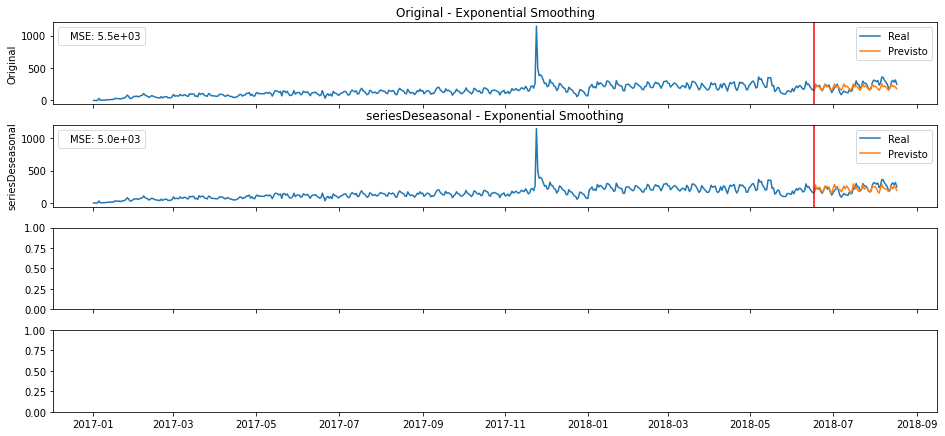

In [68]:
reportES(seriesDeseasonal.copy(), 'Deseasonal', model_kwargs, fit_kwargs, calcPredTestseriesDeseasonal)

## 3.7 BoxCox - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesHistory para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [69]:
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [70]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSES(seriesBoxCox.copy(), 'BoxCox',\
                                            x.alpha, x.beta, x.gamma, calcPredTestBoxCox), axis=1)

Wall time: 59.5 s


In [71]:
tuning.query('mse == mse.min() and mse != -1')

alpha  beta  gamma          mse
114    0.1   0.1    0.4  5505.869071

In [72]:
params_ = exp_smoothing_configs([FEATURES])

In [73]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [74]:
%%time
if EXECUTE_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSESOPT(seriesBoxCox.copy(), 'BoxCox',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestBoxCox),\
                                   axis = 1)

Wall time: 4min 24s


In [75]:
if EXECUTE_GRID_SEARCH:
    display(tuning2.query('mse == mse.min() and mse != -1'))

trend season  periods  bias method          mse
44   mul    add        5  True  SLSQP  3185.390396

In [76]:
model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=FEATURES)
fit_kwargs = dict(remove_bias = True, smoothing_level = 0.1, smoothing_trend = 0.1, smoothing_seasonal = 0.4,\
                  method = 'Powell')

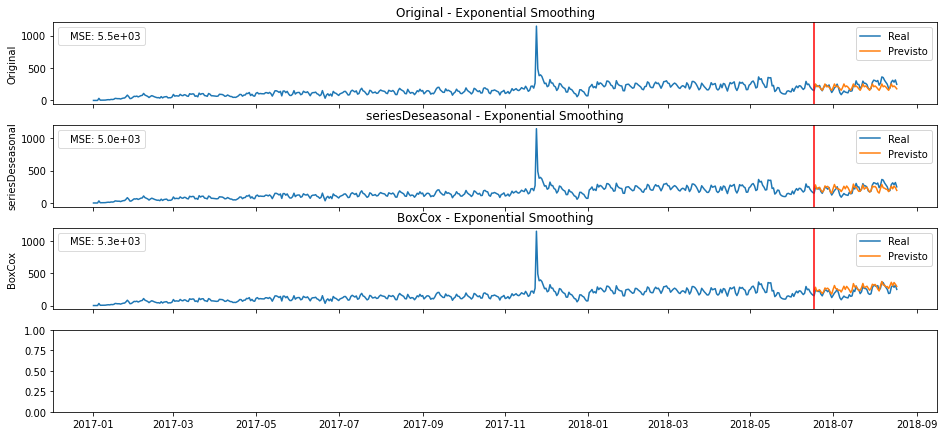

In [77]:
reportES(seriesBoxCox.copy(), 'BoxCox', model_kwargs, fit_kwargs, calcPredTestBoxCox)

## 3.8 Seasonal - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesHistory para seriesDiffHistory, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [78]:
alphas = betas = gammas = np.arange(1, step=0.1)
tuning = pd.DataFrame(product(alphas, betas, gammas), columns=['alpha', 'beta', 'gamma'])
tuning.head()

alpha  beta  gamma
0    0.0   0.0    0.0
1    0.0   0.0    0.1
2    0.0   0.0    0.2
3    0.0   0.0    0.3
4    0.0   0.0    0.4

In [79]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSES(seriesDiffHistory.copy(), 'Stationary',\
                                            x.alpha, x.beta, x.gamma, calcPredTestStationary), axis=1)

Wall time: 1min 7s


In [80]:
tuning.query('mse == mse.min() and mse != -1')

alpha  beta  gamma           mse
10    0.0   0.1    0.0  43322.617424

In [81]:
params_ = exp_smoothing_configs([FEATURES])

In [82]:
tuning2 = pd.DataFrame(params_, columns=['trend', 'season', 'periods', 'bias', 'method'])

In [83]:
%%time
if EXECUTE_GRID_SEARCH:
    tuning2['mse'] = tuning2.apply(lambda x: GSESOPT(seriesDiffHistory.copy(), 'Stationary',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestStationary),\
                                   axis = 1)

Wall time: 2min 3s


In [84]:
if EXECUTE_GRID_SEARCH:
    display(tuning2.query('mse == mse.min() and mse != -1'))

Empty DataFrame
Columns: [trend, season, periods, bias, method, mse]
Index: []

In [85]:
model_kwargs = dict(trend='add', seasonal='add', seasonal_periods=FEATURES)
fit_kwargs = dict(remove_bias = False, smoothing_level = 0, smoothing_trend = 0.3, smoothing_seasonal = 0.0,\
                  method = 'ls')

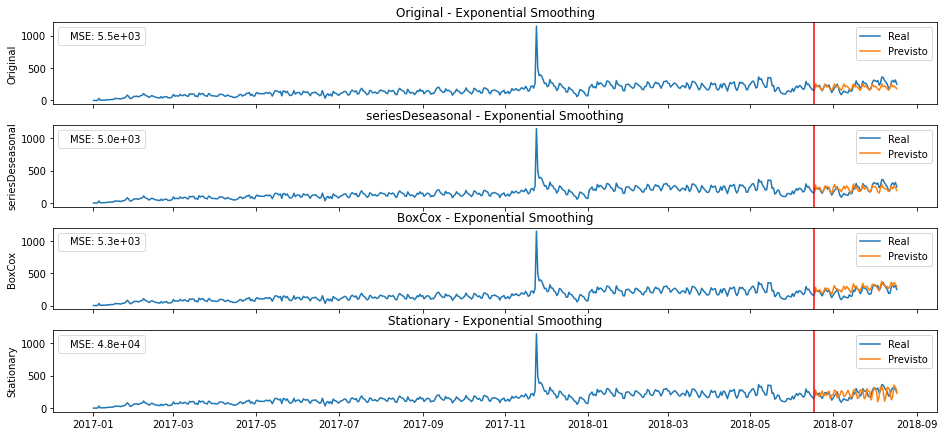

In [86]:
reportES(seriesDiffHistory.copy(), 'Stationary', model_kwargs, fit_kwargs, calcPredTestStationary)

In [87]:
result

Algorithm           MSE        RMSE  \
0          Original - Time Series Regression   5485.688752   63.032946   
1  seriesDeseasonal - Time Series Regression   5070.936469   57.842363   
2            BoxCox - Time Series Regression   5531.781002   63.453289   
3        Stationary - Time Series Regression  20765.011179  123.412496   
4           Original - Exponential Smoothing   5523.286110   60.505490   
5   seriesDeseasonal - Exponential Smoothing   4995.372698   57.454750   
6             BoxCox - Exponential Smoothing   5295.550187   60.651937   
7         Stationary - Exponential Smoothing  48372.797532  196.181759   

          MAE  Mean_Real_Value  Mean_Predict_Value  
0   45.057261       179.560484          164.066513  
1   39.592783       179.560484          166.267257  
2   45.576572       179.560484          160.984010  
3   88.116806       181.296371          175.123977  
4   41.256041       179.560484          170.716575  
5   38.814970       179.560484          167.407451  
6   41.800642       179.560484          174.995807  
7  141.789213       181.296371          178.154333

## 3.9 ARIMA

In [88]:
# Report do algoritmo arima, também é adicionado a base de resultados e realizado o plot de acompanhamento
def reportArima(arimaModel, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - '  + arimaModel.__str__().strip()
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        arimaModel.fit(train)
        pred = arimaModel.predict(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [89]:
# Reset da figura
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

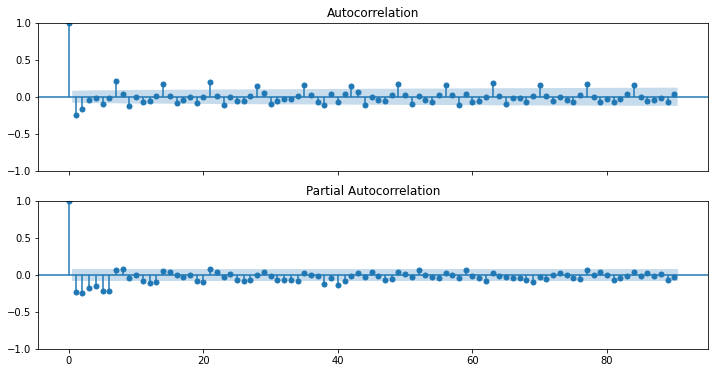

In [90]:
# Correlação entre os periodos com ARIMA

lags = 90

with catch_warnings():
    filterwarnings("ignore")
    fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True)
    plot_acf(seriesHistory.diff().dropna(), ax = ax[0], lags = lags, missing = 'drop')
    plot_pacf(seriesHistory.diff().dropna(), ax = ax[1], lags = lags)
    plt.show()

In [91]:
%%time

# Utilizando o auto arima para descobrir os argumentos ideias baseados no conjunto de dado informado
data = seriesHistory.copy()
arimaModel = auto_arima(seriesHistory.copy(), m = FEATURES)
arimaModel

Wall time: 17.7 s


ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 5),
      suppress_warnings=True, with_intercept=False)

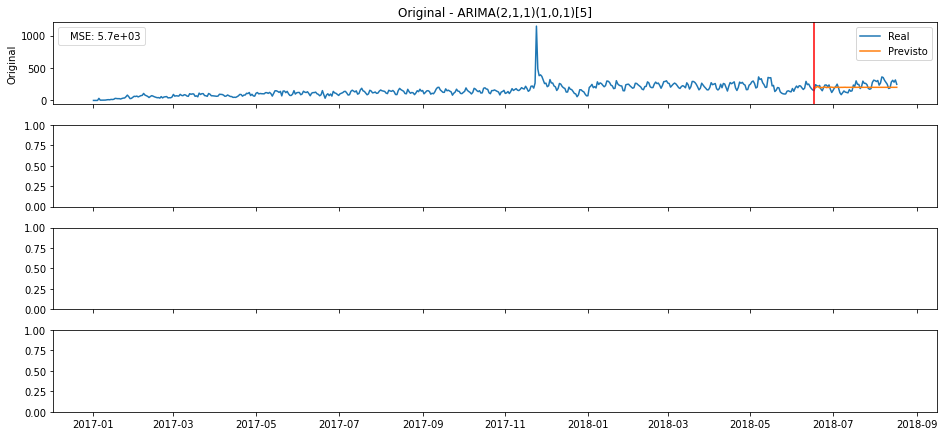

In [92]:
reportArima(arimaModel, 'Original', calcPredTestOriginal)

## 3.10 seriesDeseasonal - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesHistory para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [93]:
%%time
data = seriesDeseasonal.copy()
arimaModel = auto_arima(data, seasonal = False)
arimaModel

Wall time: 2.59 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

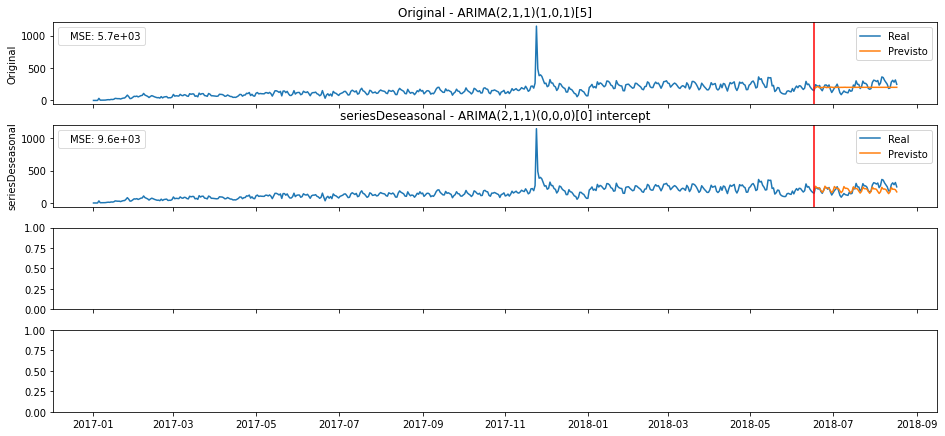

In [94]:
reportArima(arimaModel, 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.11 BoxCox - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesHistory para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [95]:
%%time
data = seriesBoxCox.copy()
arimaModel = auto_arima(data, m = FEATURES)
arimaModel

Wall time: 36.4 s


ARIMA(order=(4, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 5),
      suppress_warnings=True)

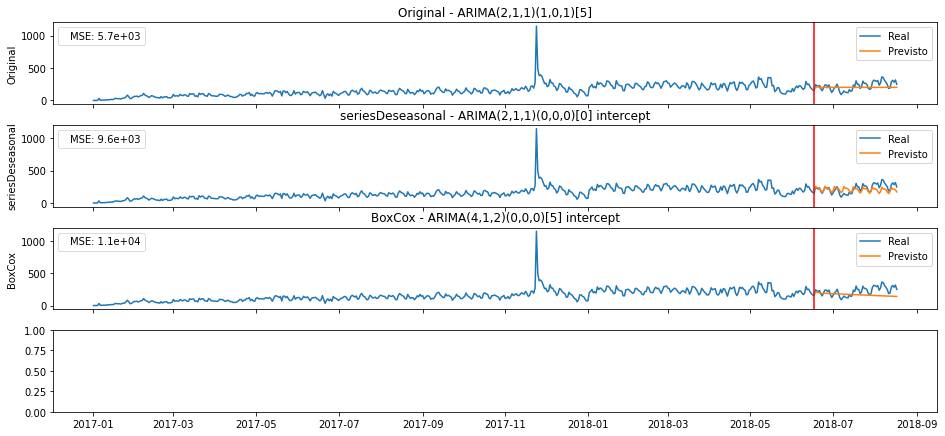

In [96]:
reportArima(arimaModel, 'BoxCox', calcPredTestBoxCox)

## 3.12 Stationary - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [97]:
%%time
data = seriesDiffHistory.copy()
arimaModel = auto_arima(data, seasonal = False)
arimaModel

Wall time: 12 s


ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True)

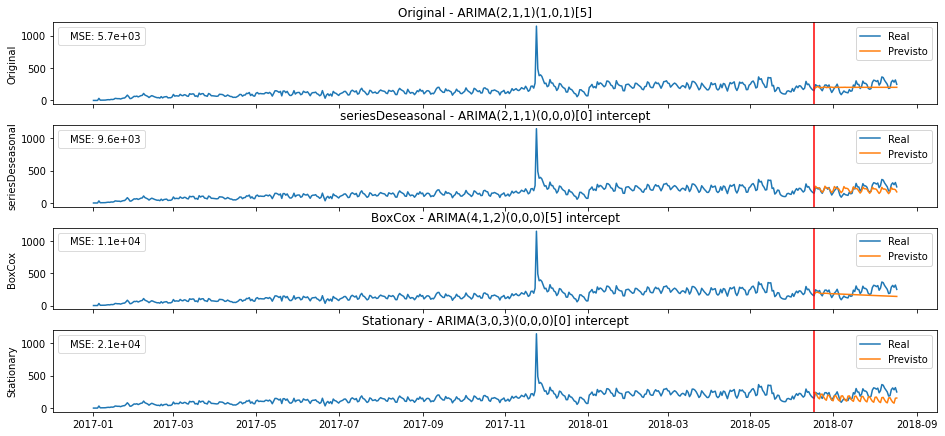

In [98]:
reportArima(arimaModel, 'Stationary', calcPredTestStationary)

In [99]:
result

Algorithm           MSE  \
0                   Original - Time Series Regression   5485.688752   
1           seriesDeseasonal - Time Series Regression   5070.936469   
2                     BoxCox - Time Series Regression   5531.781002   
3                 Stationary - Time Series Regression  20765.011179   
4                    Original - Exponential Smoothing   5523.286110   
5            seriesDeseasonal - Exponential Smoothing   4995.372698   
6                      BoxCox - Exponential Smoothing   5295.550187   
7                  Stationary - Exponential Smoothing  48372.797532   
8                   Original - ARIMA(2,1,1)(1,0,1)[5]   5734.428304   
9   seriesDeseasonal - ARIMA(2,1,1)(0,0,0)[0] inte...   9591.508344   
10          BoxCox - ARIMA(4,1,2)(0,0,0)[5] intercept  11293.369481   
11      Stationary - ARIMA(3,0,3)(0,0,0)[0] intercept  21477.900281   

          RMSE         MAE  Mean_Real_Value  Mean_Predict_Value  
0    63.032946   45.057261       179.560484          164.066513  
1    57.842363   39.592783       179.560484          166.267257  
2    63.453289   45.576572       179.560484          160.984010  
3   123.412496   88.116806       181.296371          175.123977  
4    60.505490   41.256041       179.560484          170.716575  
5    57.454750   38.814970       179.560484          167.407451  
6    60.651937   41.800642       179.560484          174.995807  
7   196.181759  141.789213       181.296371          178.154333  
8    64.119816   46.036502       179.560484          168.922406  
9    77.052176   59.641647       179.560484          191.565756  
10   88.024735   69.332624       179.560484          190.689776  
11  124.896247   86.287046       181.296371          160.562751

## 3.13 LSTM

In [100]:
# Redefinindo variaveis globais para o treino utilizando LSTM

BATCH_SIZE = 30
FEATURES = 5

In [101]:
# Hypertuning do algoritmo de LSTM
def GSLSTM(data, learning_rate, calcFunction):
    mse = []
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        try:
            with catch_warnings():
                filterwarnings("ignore")
                
                # Normalização e reshape do conjunto de treino
                ss = StandardScaler()
                ss.fit(train.values.reshape(-1, 1))
                train_input = ss.transform(train.values.reshape(-1, 1))
                
                # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
                test_input = train_input[-(FEATURES + 1):]
                test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reset da sessão
                clear_session()
                
                # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
                initializer = GlorotUniform(seed = SEED)
                model = Sequential()
                
                # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
                model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
                model.add(Dense(1, kernel_initializer = initializer))
                model.add(BatchNormalization())
                model.add(Dense(1, kernel_initializer = initializer))
                
                # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
                early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
                
                # Treinando o modelo com otimizador Adam
                model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
                h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
                pred = np.empty(test.shape[0])
                
                # Realizando predições no conjunto de teste
                for i in range(len(pred)):
                    prediction = model.predict(test_gen, verbose = False)
                    pred[i] = prediction
                    test_input = np.delete(test_input, 0, 0)
                    test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
                    test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reorganizando o shape e chamando a função de calculo
                pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
                pred, test, _ = calcFunction(train, pred, test)      

                mse.append(mean_squared_error(pred, test))
                
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [102]:
# Report do algoritmo LSTM
def reportLSTM(data, modelName, calcFunction, learning_rate):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Long Short Term Memory (LSTM)'
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        # Normalização e reshape do conjunto de treino
        ss = StandardScaler()
        ss.fit(train.values.reshape(-1, 1))
        train_input = ss.transform(train.values.reshape(-1, 1))

        # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
        test_input = train_input[-(FEATURES + 1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
        train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reset da sessão
        clear_session()
        
        # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
        initializer = GlorotUniform(seed = SEED)
        model = Sequential()
        
        # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
        model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
        model.add(Dense(1, kernel_initializer = initializer))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer = initializer))
        
        # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
        early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
        
        # Treinando o modelo com otimizador Adam
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
        h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
        pred = np.empty(test.shape[0])

        # Realizando predições no conjunto de teste
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose = False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
            test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reorganizando o shape e chamando a função de calculo
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [103]:
# Gerando tabela de hypertunning com taxas de learning_rate
learning_rates = np.logspace(-5, 1, 7)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [104]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSLSTM(seriesHistory.copy(), x.learning_rate, calcPredTestOriginal), axis=1)

Wall time: 3min 25s


In [105]:
tuning.query('mse == mse.min() and mse != -1')

learning_rate          mse
2          0.001  5534.529757

In [106]:
# Reset da figura
figs, axs = plt.subplots(nrows=4, sharex=True, figsize=(13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

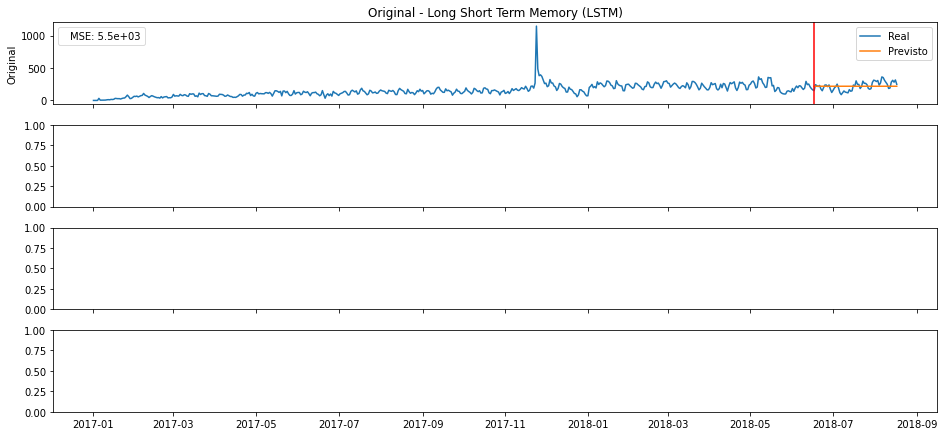

In [107]:
reportLSTM(seriesHistory.copy(), 'Original', calcPredTestOriginal, 0.0001)

## 3.14 seriesDeseasonal - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [108]:
learning_rates = np.logspace(-5, 1, 7)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [109]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSLSTM(seriesDeseasonal.copy(), x.learning_rate, calcPredTestseriesDeseasonal), axis=1)

Wall time: 3min 24s


In [110]:
tuning.query('mse == mse.min() and mse != -1')

learning_rate          mse
3           0.01  5116.345705

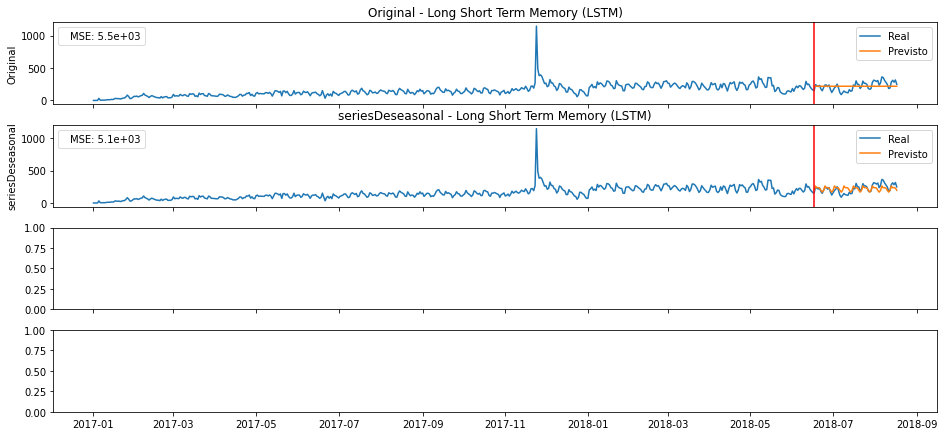

In [111]:
reportLSTM(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal, 0.0001)

## 3.15 BoxCox - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [112]:
learning_rates = np.logspace(-5, 1, 7)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [113]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSLSTM(seriesBoxCox.copy(), x.learning_rate, calcPredTestBoxCox), axis=1)

Wall time: 3min 27s


In [114]:
tuning.query('mse == mse.min() and mse != -1')

learning_rate          mse
3           0.01  5557.541479

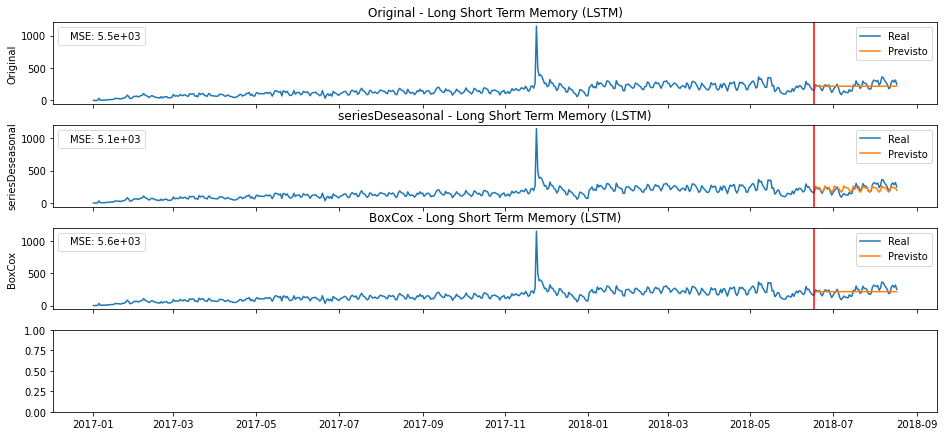

In [115]:
reportLSTM(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox, 0.0001)

## 3.16 Stationary - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [116]:
learning_rates = np.logspace(-5, 1, 7)
tuning = pd.DataFrame(learning_rates, columns=['learning_rate'])
tuning.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [117]:
%%time
tuning['mse'] = tuning.apply(lambda x: GSLSTM(seriesDiffHistory.copy(), x.learning_rate, calcPredTestStationary), axis=1)

Wall time: 3min 25s


In [118]:
tuning.query('mse == mse.min() and mse != -1')

learning_rate           mse
0        0.00001  19690.268648

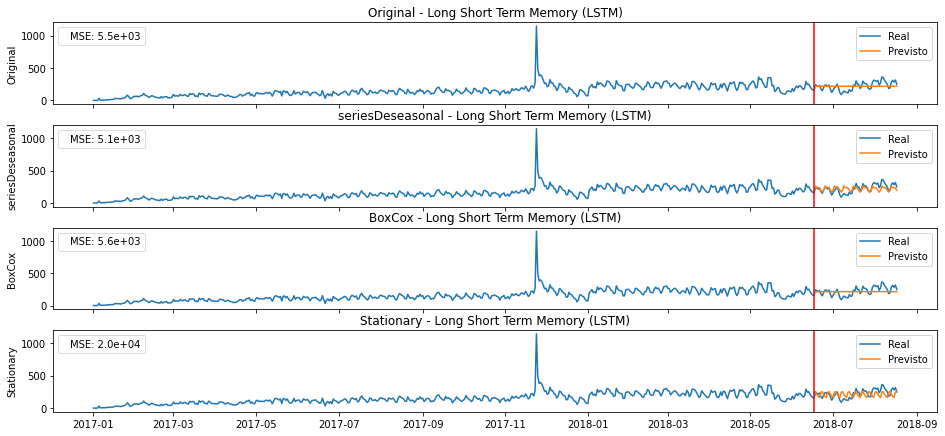

In [119]:
reportLSTM(seriesDiffHistory.copy(), 'Stationary', calcPredTestStationary, 0.0001)

In [120]:
result

Algorithm           MSE  \
0                   Original - Time Series Regression   5485.688752   
1           seriesDeseasonal - Time Series Regression   5070.936469   
2                     BoxCox - Time Series Regression   5531.781002   
3                 Stationary - Time Series Regression  20765.011179   
4                    Original - Exponential Smoothing   5523.286110   
5            seriesDeseasonal - Exponential Smoothing   4995.372698   
6                      BoxCox - Exponential Smoothing   5295.550187   
7                  Stationary - Exponential Smoothing  48372.797532   
8                   Original - ARIMA(2,1,1)(1,0,1)[5]   5734.428304   
9   seriesDeseasonal - ARIMA(2,1,1)(0,0,0)[0] inte...   9591.508344   
10          BoxCox - ARIMA(4,1,2)(0,0,0)[5] intercept  11293.369481   
11      Stationary - ARIMA(3,0,3)(0,0,0)[0] intercept  21477.900281   
12           Original - Long Short Term Memory (LSTM)   5544.852289   
13   seriesDeseasonal - Long Short Term Memory (LSTM)   5137.939093   
14             BoxCox - Long Short Term Memory (LSTM)   5619.469483   
15         Stationary - Long Short Term Memory (LSTM)  20133.750206   

          RMSE         MAE  Mean_Real_Value  Mean_Predict_Value  
0    63.032946   45.057261       179.560484          164.066513  
1    57.842363   39.592783       179.560484          166.267257  
2    63.453289   45.576572       179.560484          160.984010  
3   123.412496   88.116806       181.296371          175.123977  
4    60.505490   41.256041       179.560484          170.716575  
5    57.454750   38.814970       179.560484          167.407451  
6    60.651937   41.800642       179.560484          174.995807  
7   196.181759  141.789213       181.296371          178.154333  
8    64.119816   46.036502       179.560484          168.922406  
9    77.052176   59.641647       179.560484          191.565756  
10   88.024735   69.332624       179.560484          190.689776  
11  124.896247   86.287046       181.296371          160.562751  
12   63.906804   45.909975       179.560484          160.940186  
13   59.474598   41.559466       179.560484          160.899923  
14   64.576115   46.701091       179.560484          157.287922  
15  120.711938   86.471191       181.296371          183.886518

## 4. Comparação

In [121]:
# Tratando nomes e criando colunas de controle para os resultados gerados
topResult = (
    result 
    .assign(Full_Name = lambda x: x.Algorithm.apply(lambda a: a.split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .assign(Data_Category = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[0]))
    .assign(Algorithm = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[1].split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .sort_values('MSE')
)

In [122]:
topResult.head()

Algorithm          MSE       RMSE        MAE  \
5    Exponential Smoothing  4995.372698  57.454750  38.814970   
1   Time Series Regression  5070.936469  57.842363  39.592783   
13                   LSTM   5137.939093  59.474598  41.559466   
6    Exponential Smoothing  5295.550187  60.651937  41.800642   
0   Time Series Regression  5485.688752  63.032946  45.057261   

    Mean_Real_Value  Mean_Predict_Value  \
5        179.560484          167.407451   
1        179.560484          166.267257   
13       179.560484          160.899923   
6        179.560484          174.995807   
0        179.560484          164.066513   

                                    Full_Name     Data_Category  
5    seriesDeseasonal - Exponential Smoothing  seriesDeseasonal  
1   seriesDeseasonal - Time Series Regression  seriesDeseasonal  
13                   seriesDeseasonal - LSTM   seriesDeseasonal  
6              BoxCox - Exponential Smoothing            BoxCox  
0           Original - Time Series Regression          Original

In [123]:
# Plot dos resultados obtidos por ordem ascendente do MSE

colors = {'Time Series Regression':'red',
          'Exponential Smoothing':'orange',
          'Auto Arima': 'green',
          'LSTM ': 'blue'}

# plotly figure
fig = go.Figure(layout = go.Layout(yaxis = {"type": "category", 'title': 'Algoritmo e Categoria'},
                        xaxis = {'title': 'MSE'},
                        title = 'MSE por Algoritmo e Tipo de Dado'))

for t in topResult['Algorithm'].unique():
    topResultFiltered = topResult[topResult['Algorithm']==t].copy()
    fig.add_traces(go.Bar(x = topResultFiltered['MSE'], y = topResultFiltered['Full_Name'], name = str(t),\
                          marker_color = str(colors[t]), orientation = 'h',
                          text = round(topResultFiltered['MSE']), textposition = 'outside'))
    
    
fig.update_layout(yaxis={'categoryorder':'total descending'}, autosize = False,
                  width = 1450,
                  height = 800)    
    
fig.show()